In [1]:
#import packages
#feel free to import more if you need
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

In [143]:

#evaluate the benign accuracy of a model
def test(model, x,y,batch_size):
    model.eval()
    total=x.shape[0]
    batches=np.ceil(total/batch_size).astype(int)
    success=0
    loss=0
    for i in range(batches):
        start_index=i*batch_size
        end_index=np.minimum((i+1)*batch_size,total)
        x_batch=torch.tensor(x[start_index:end_index]).float()
        y_batch=torch.tensor(y[start_index:end_index]).long()
        output=model(x_batch)
        pred=torch.argmax(output,dim=1)
        loss+=F.cross_entropy(output,y_batch).item()
        success+=(pred==y_batch).sum().item()
    print ("accuracy: "+str(success/total))
    return success/total


In [144]:
#define model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x=self.conv1(x)
        x=F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [145]:
# from recitation
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
norm = Normalize(mean=[0.485], std=[0.229]) # for one channel

In [146]:
#load MNIST
dataset_train = datasets.MNIST('../data', train=True, download=True)
dataset_test = datasets.MNIST('../data', train=False, download=True)

# reshape MNIST
x_train=dataset_train.data.numpy()
y_train=dataset_train.targets.numpy()
x_test=dataset_test.data.numpy()
y_test=dataset_test.targets.numpy()
x_train=np.reshape(x_train,(60000,28,28,1))
x_test=np.reshape(x_test,(10000,28,28,1))
x_train=np.swapaxes(x_train, 1, 3)
x_test=np.swapaxes(x_test, 1, 3)

In [147]:
#REMINDER: the range of inputs is different from what we used in the recitation
print (x_test.min(),x_test.max())
print(x_test.shape)
print(y_test)

0 255
(10000, 1, 28, 28)
[7 2 1 ... 4 5 6]


In [171]:
modelA=Net()
modelA.load_state_dict(torch.load("modelA.zip"))
model_A_ref_acc = test(modelA,x_test,y_test,10000)
modelB=Net()
modelB.load_state_dict(torch.load("modelB.zip"))
model_B_ref_acc = test(modelB,x_test,y_test,10000)

accuracy: 0.9856
accuracy: 0.9839


In [197]:
def attack_plot(purturbed_images, test_images, index, name, epsilon, model ='A', n_iter= None):
    fig, ax = plt.subplots(1, 2)
    purturbed_images = purturbed_images.squeeze().detach().numpy()
    test_images = test_images.squeeze()
    
    ax[0].imshow(test_images[index], cmap='gray')
    ax[0].set_title('Input Image')
    
    ax[1].imshow(purturbed_images[index], cmap='gray')
    ax[1].set_title('Purtured Image')
    fig.tight_layout()
    if n_iter:
        fig.suptitle(f'{name} attack with epsilon {epsilon}, n_iter {n_iter}')
        fig.savefig(f'{name}/{name}_attack__mod{model}_{epsilon}_Img-{index}_iter{n_iter}.png')
    else:
        fig.suptitle(f'{name} attack with epsilon {epsilon}')
        fig.savefig(f'{name}/{name}_attack__mod{model}_{epsilon}_Img-{index}.png')
    plt.show()

In [184]:
#untargeted attack
def untargeted_attack(input, label, model, epsilon):
    x = input.detach().clone()
    x.requires_grad = True
    
    x_norm = norm(x) # normalize
    pred_old = model(x_norm)
    
    model.zero_grad()
    # print('pred old', pred_old.shape)
    # print('pred new',  label.shape)

    loss= nn.CrossEntropyLoss()(pred_old, label)
    loss.backward()
    gradient = x.grad
    # print(gradient.shape)
    with torch.no_grad():
        x = x + epsilon*gradient.sign()
        eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
        x = torch.clamp(input + eta, min=0, max=1).detach().clone()
        x = torch.round(x*255)/255
    pred_new = model(norm(x))
    return x, pred_new 

____________________________________________________________________
Model A
Epsilon: 0.05


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.1094
Success rate of the untargeted attack: 0.6484
Accuracy of the model on adversarial inputs: 0.1094
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8762


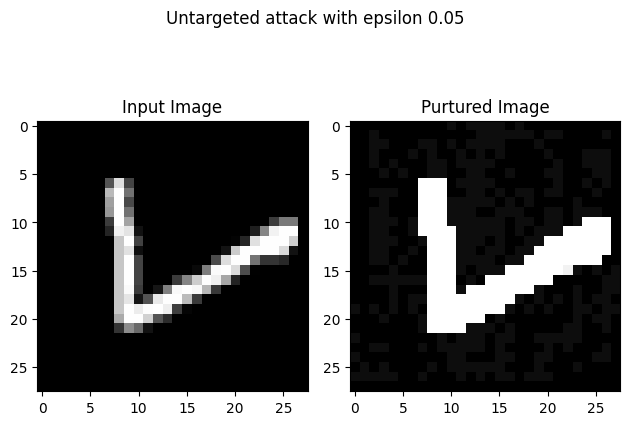

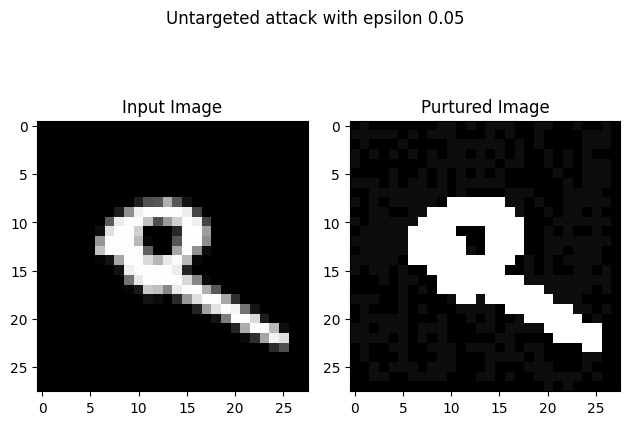

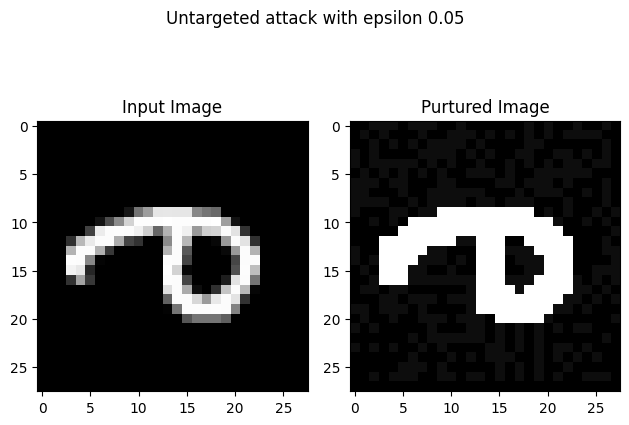

____________________________________________________________________
Model A
Epsilon: 0.1
accuracy: 0.1045
Success rate of the untargeted attack: 0.6558
Accuracy of the model on adversarial inputs: 0.1045
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8811


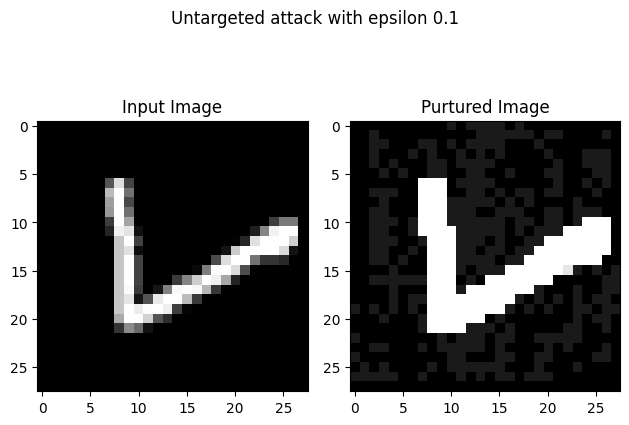

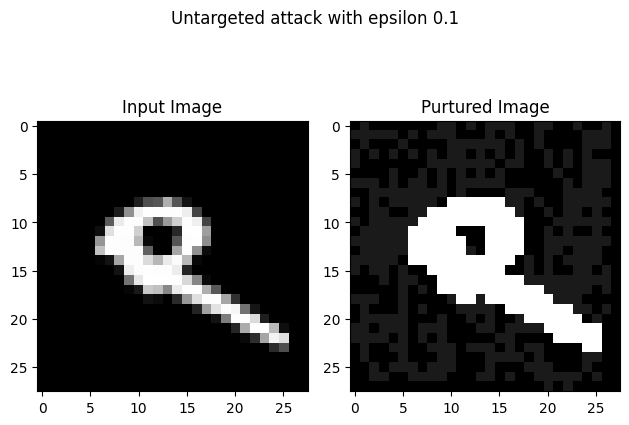

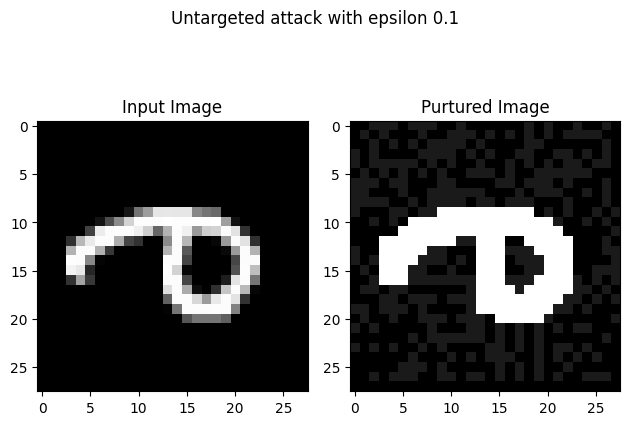

In [185]:
epsilon_list = [.05, .1]
for epsilon in epsilon_list:
    adversarial_inputs = []
    pred_adv = []
    print('____________________________________________________________________')
    print('Model A')
    print('Epsilon:', epsilon)
    modelA.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        # print('input label', input_label.shape)
        x, pred = untargeted_attack(input_tensor, input_label, modelA, epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(x)

    pred_adv = torch.cat(pred_adv, dim=0)
    adversarial_inputs = torch.cat(adversarial_inputs, dim=0)
    success_rate = np.sum(torch.argmax(pred_adv, dim=1).numpy() != y_test) / len(y_test)
    adv_accuracy = test(modelA, adversarial_inputs, y_test, 10000)

    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {adv_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')
    print(f'Difference in accuracy: {model_A_ref_acc - adv_accuracy:.4f}')
    attack_plot(purturbed_images=adversarial_inputs, test_images=x_test, index=0, name='Untargeted', epsilon=epsilon, model = 'A')
    attack_plot(purturbed_images=adversarial_inputs, test_images=x_test, index=7, name='Untargeted', epsilon=epsilon, model = 'A')
    attack_plot(purturbed_images=adversarial_inputs, test_images=x_test, index=21, name='Untargeted', epsilon=epsilon, model = 'A')

____________________________________________________________________
ModelB
Epsilon: 0.05


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.1135
Success rate of the untargeted attack: 0.8865
Accuracy of the model on adversarial inputs: 0.1135
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8721


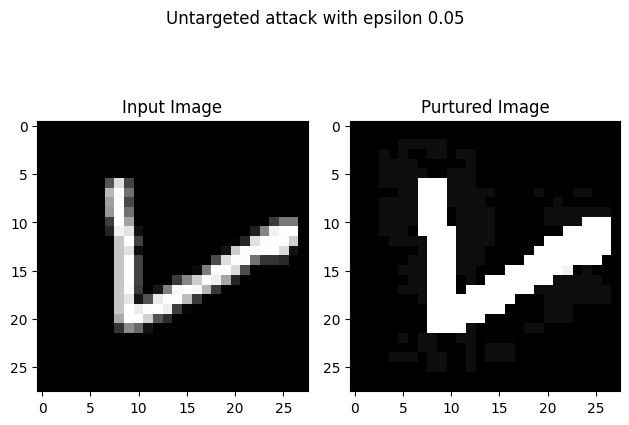

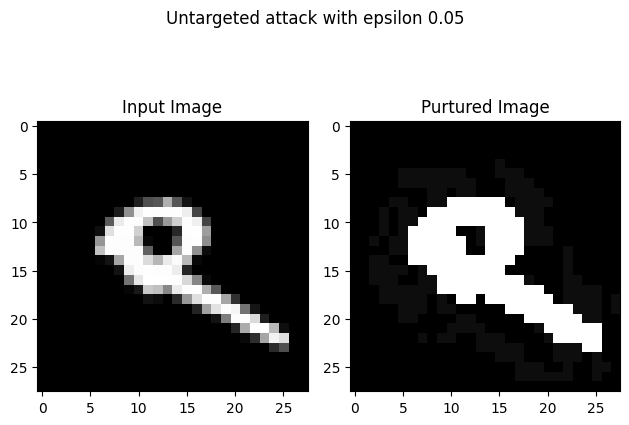

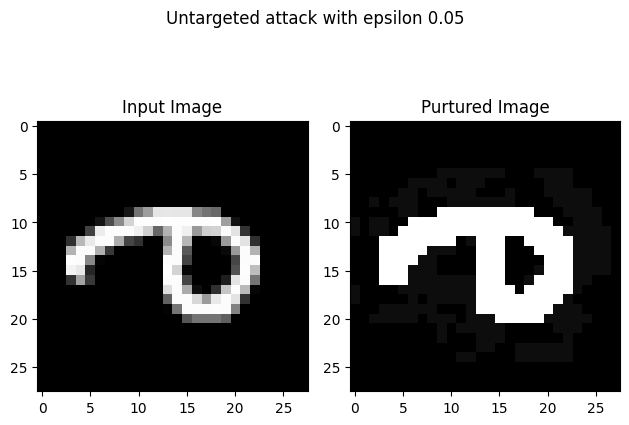

____________________________________________________________________
ModelB
Epsilon: 0.1
accuracy: 0.1135
Success rate of the untargeted attack: 0.8865
Accuracy of the model on adversarial inputs: 0.1135
Accuracy of the model on inputs was: 0.9856
Difference in accuracy: 0.8721


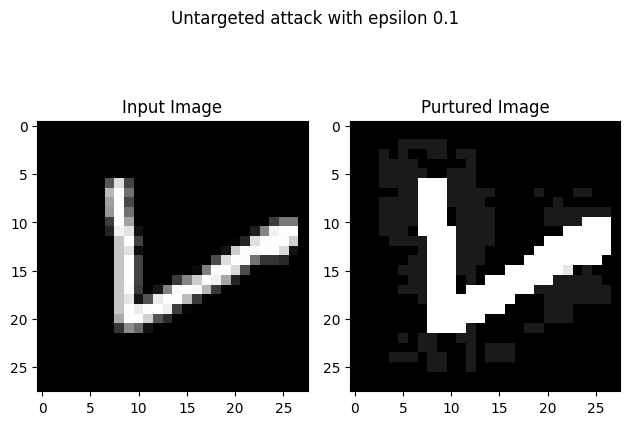

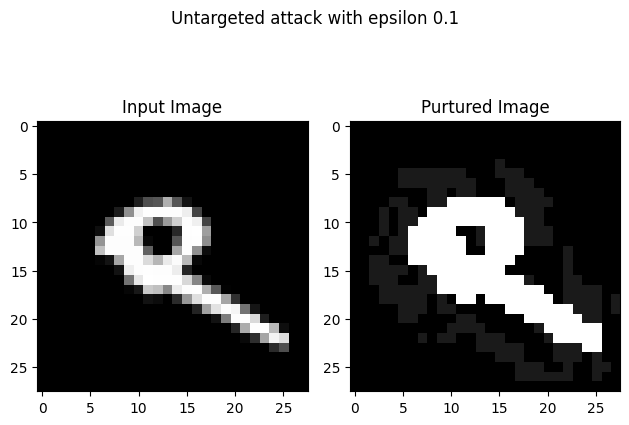

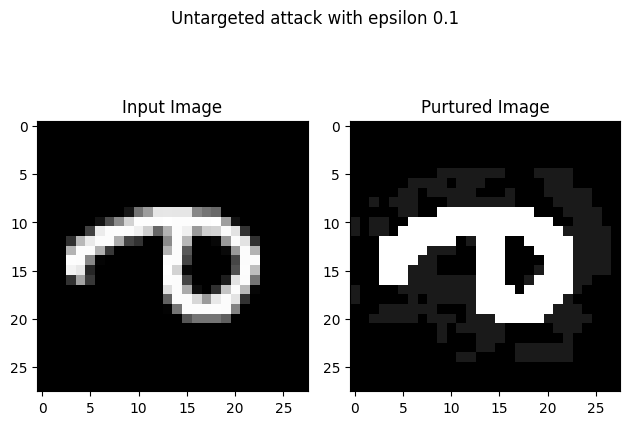

In [186]:
epsilon_list = [.05, .1]
for epsilon in epsilon_list:
    adversarial_inputs = []
    pred_adv = []
    print('____________________________________________________________________')
    print('ModelB')
    print('Epsilon:', epsilon)
    modelB.eval()
    for i in range(len(y_test)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        # print('input label', input_label.shape)
        x, pred = untargeted_attack(input_tensor, input_label, modelB, epsilon)
        pred_adv.append(pred)
        adversarial_inputs.append(x)

    pred_adv = torch.cat(pred_adv, dim=0)
    adversarial_inputs = torch.cat(adversarial_inputs, dim=0)
    success_rate = np.sum(torch.argmax(pred_adv, dim=1).numpy() != y_test) / len(y_test)
    adv_accuracy = test(modelB, adversarial_inputs, y_test, 10000)

    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {adv_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')
    print(f'Difference in accuracy: {model_A_ref_acc - adv_accuracy:.4f}')
    attack_plot(purturbed_images=adversarial_inputs, test_images=x_test, index=0, name='Untargeted', epsilon=epsilon, model = 'B')
    attack_plot(purturbed_images=adversarial_inputs, test_images=x_test, index=7, name='Untargeted', epsilon=epsilon, model = 'B')
    attack_plot(purturbed_images=adversarial_inputs, test_images=x_test, index=21, name='Untargeted', epsilon=epsilon, model = 'B')

# Targeted Attack

In [188]:
# #targeted attack
# #you may add parameters as you wish
# def iterative_fgsm(input, label, model, epsilon, n_iter=100,class_to_attack=1, target_class=8):
    
#     if label != class_to_attack:
#         return input, model(input)
    
#     else: # label == class_to_attack
#         x = input.detach().clone()
#         x.requires_grad = True
#         target_class_tensor = torch.tensor([target_class], dtype=torch.long)
#         for iter in n_iter:
#             x_norm = norm(x) # normalize
#             prediction = model(x_norm)
            
#             model.zero_grad()
#             loss= nn.CrossEntropyLoss()(prediction, target_class_tensor)
#             loss.backward()
#             gradient = x.grad
#             # print(gradient.shape)
#             with torch.no_grad():
#                 x = x - epsilon*gradient.sign()
#                 eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
#                 x = torch.clamp(input + eta, min=0, max=1).detach().clone()
#                 x = torch.round(x*255)/255
#         pred_new = model(norm(x))
#         return x, pred_new 

In [240]:
# implementing projected gradient descent
def pgd_targeted(input, label, model, alpha=10/255, epsilon=100/255, n_iter=80, class_to_attack=1, target_class=8):
    target_tensor = torch.LongTensor([target_class])
    
    if label != class_to_attack:
        x = norm(input)
        prediction = model(x)
        return x, prediction
    else:
        x=input.detach().clone()
        for i in range(n_iter):
            x.requires_grad = True
            x = norm(x)
            pred=model(x)
            model.zero_grad()
            loss = nn.CrossEntropyLoss()(pred, target_tensor )
            loss.backward()
            gradient=x.grad
            
            with torch.no_grad():
                x = x - alpha*gradient.sign()
                eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
                x = torch.clamp(input + eta, min=0, max=1)
                x = x.detach().clone()
                x = torch.round(x*255)/255
           
        prediction = model(norm(x))
        return x, prediction

In [241]:
def targeted_attack_success(preds, y_test, class_to_attack=1, target_class=8):
    preds = np.array(preds)
    y_test = np.array(y_test)
    is_class_to_attack = (y_test == class_to_attack)
    correctly_attacked = (preds[is_class_to_attack] == target_class).sum()
    total_class_to_attack = is_class_to_attack.sum()
    if total_class_to_attack > 0:
        success_rate = correctly_attacked / total_class_to_attack 
    else:
        0
    return success_rate

____________________________________________________________________
Model A, epsilon: 0.05, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


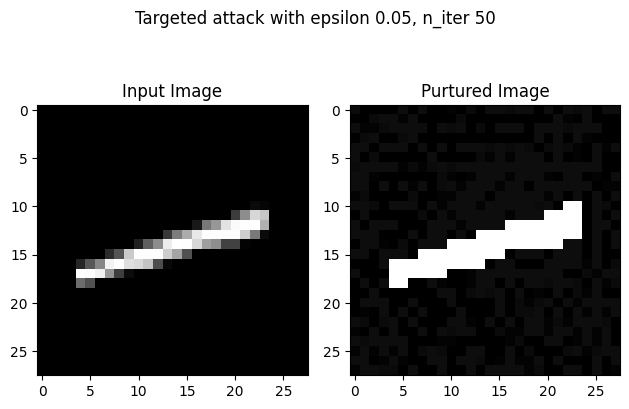

____________________________________________________________________
Model A, epsilon: 0.1, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


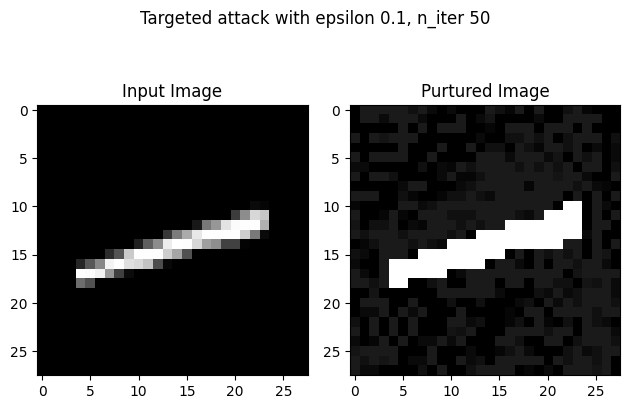

____________________________________________________________________
Model A, epsilon: 0.25, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


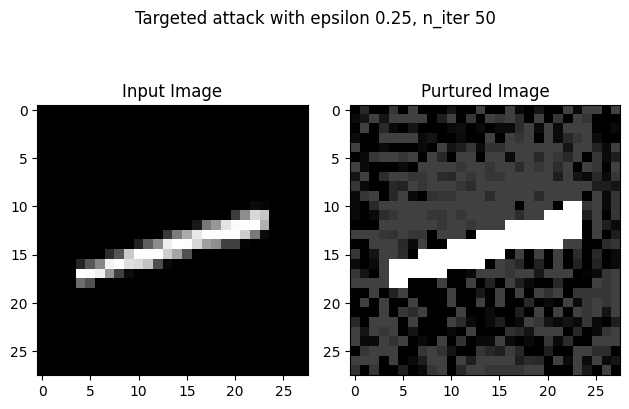

____________________________________________________________________
Model A, epsilon: 0.4, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


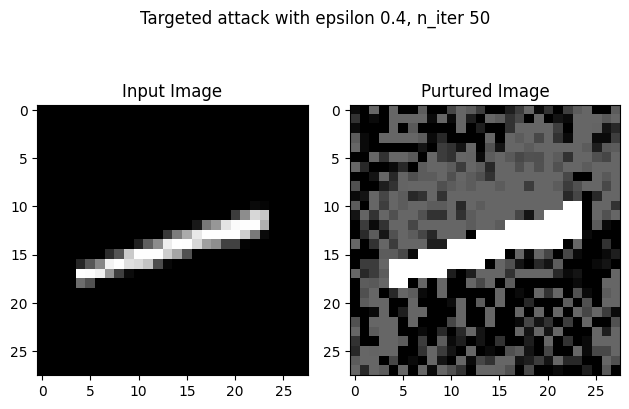

In [245]:
alpha = 10/255
n_iter = 50
model = modelA
letter = 'A'
epsilon_list =[ 0.05, .1, .25, .4]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model = 'A', n_iter=n_iter)

____________________________________________________________________
Model B, epsilon: 0.05, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


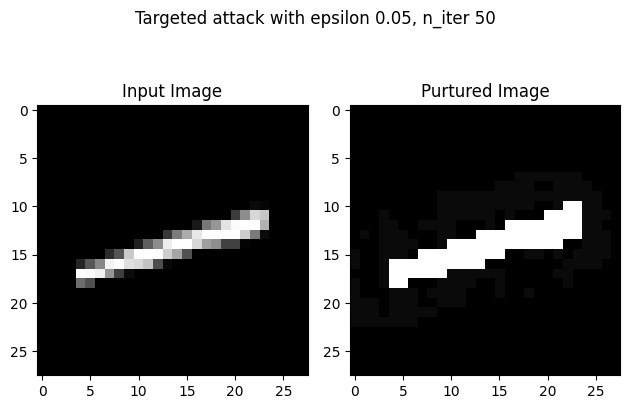

____________________________________________________________________
Model B, epsilon: 0.1, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


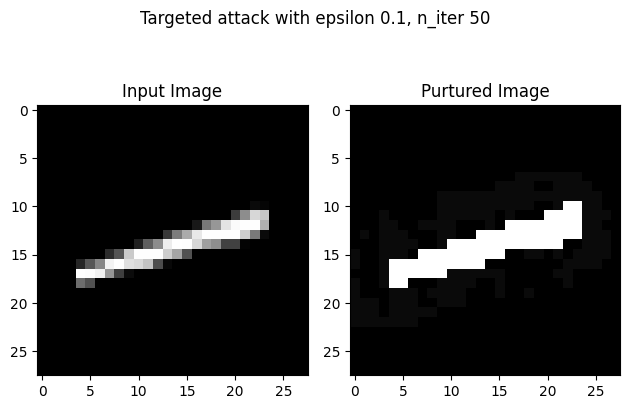

____________________________________________________________________
Model B, epsilon: 0.25, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


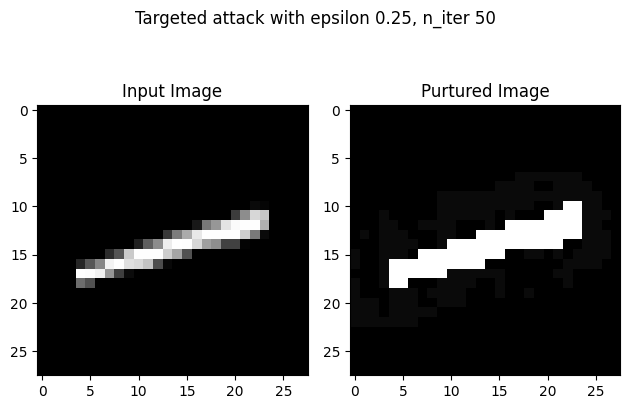

____________________________________________________________________
Model B, epsilon: 0.4, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


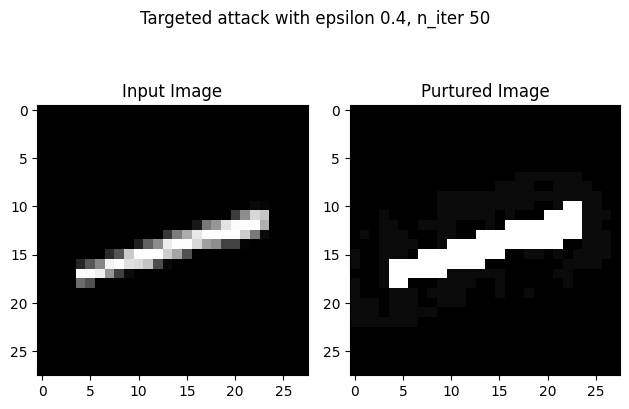

In [246]:
alpha = 10/255
n_iter = 50
model = modelB
letter = 'B'
epsilon_list =[ 0.05, .1, .25, .4]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []
    model.eval()

    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model = 'A', n_iter=n_iter)

____________________________________________________________________
Model A, epsilon: 0.05, alpha: 0.0784313725490196, n_iter: 80


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


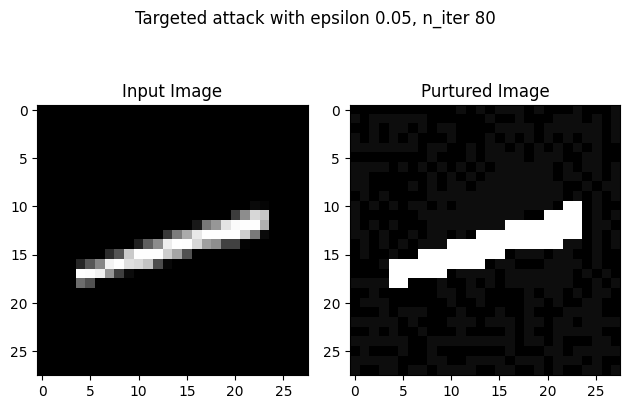

____________________________________________________________________
Model A, epsilon: 0.1, alpha: 0.0784313725490196, n_iter: 80
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


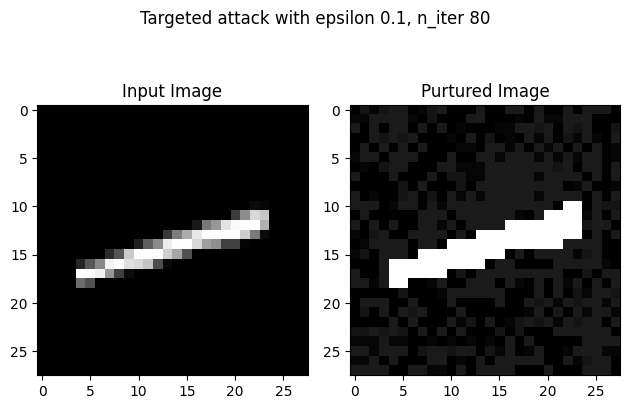

____________________________________________________________________
Model A, epsilon: 0.25, alpha: 0.0784313725490196, n_iter: 80
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


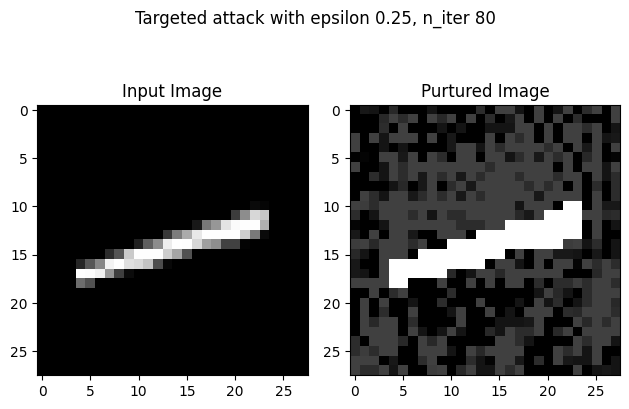

____________________________________________________________________
Model A, epsilon: 0.4, alpha: 0.0784313725490196, n_iter: 80
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


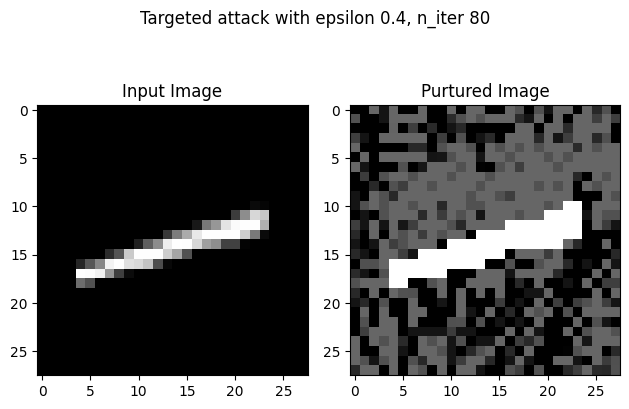

In [247]:
alpha = 20/255
n_iter = 80
model = modelA
letter = 'A'
epsilon_list =[ 0.05, .1, .25, .4]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model = 'A', n_iter=n_iter)

____________________________________________________________________
Model B, epsilon: 0.05, alpha: 0.0784313725490196, n_iter: 80


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


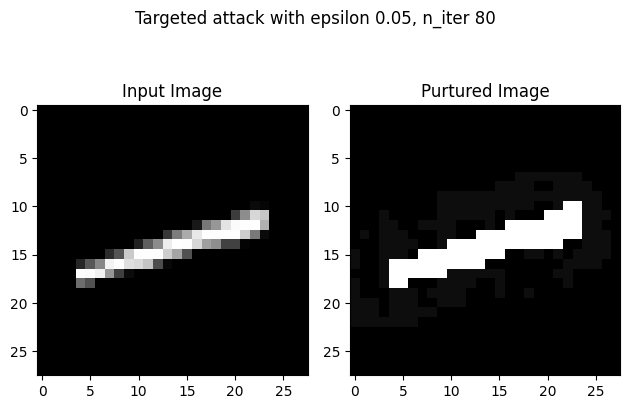

____________________________________________________________________
Model B, epsilon: 0.1, alpha: 0.0784313725490196, n_iter: 80
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


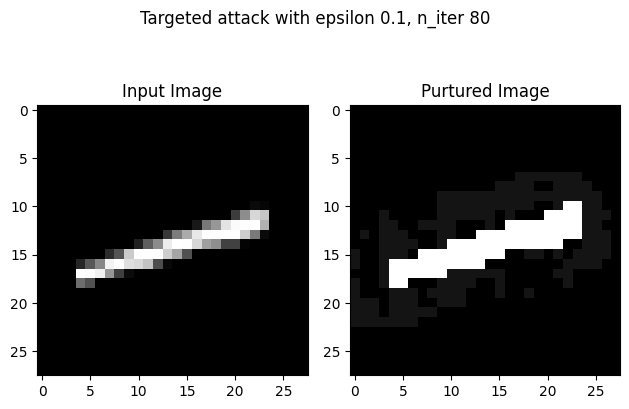

____________________________________________________________________
Model B, epsilon: 0.25, alpha: 0.0784313725490196, n_iter: 80
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


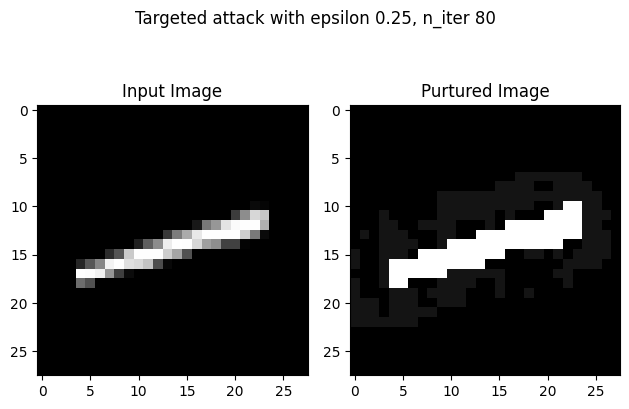

____________________________________________________________________
Model B, epsilon: 0.4, alpha: 0.0784313725490196, n_iter: 80
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


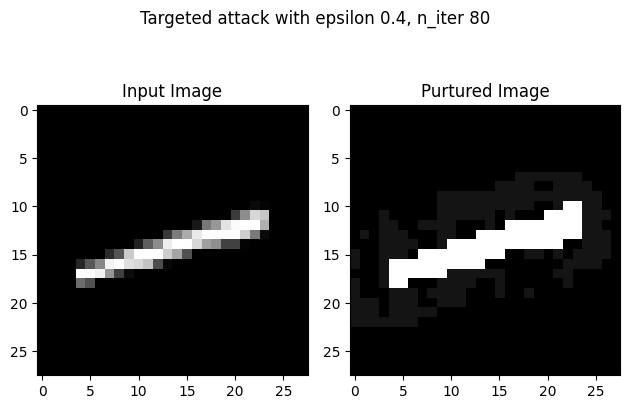

In [248]:
alpha = 20/255
n_iter = 80
model = modelB
letter = 'B'
epsilon_list =[ 0.05, .1, .25, .4]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []
    model.eval()

    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model = 'A', n_iter=n_iter)

____________________________________________________________________
Model B, epsilon: 1, alpha: 1, n_iter: 80


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the untargeted attack: 0.03171806167400881
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


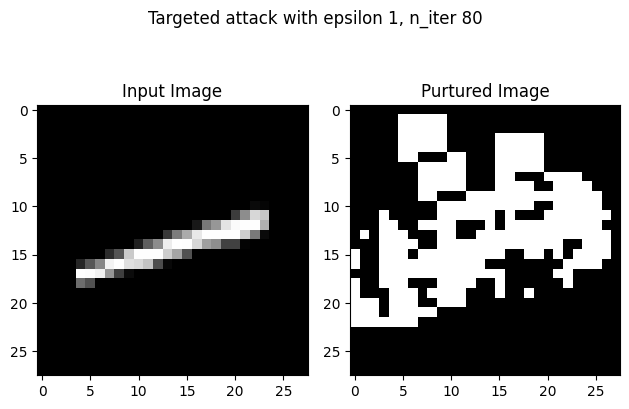

In [250]:
alpha = 1
n_iter = 80
model = modelB
letter = 'B'
epsilon_list = [1]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []
    model.eval()

    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model = 'A', n_iter=n_iter)

____________________________________________________________________
Model B, epsilon: 1, alpha: 0.8, n_iter: 100


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


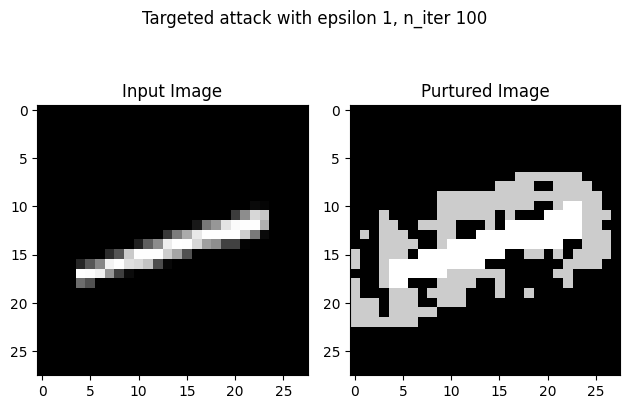

In [252]:
alpha = .8
n_iter = 100
model = modelB
letter = 'B'
epsilon_list = [1]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []
    model.eval()

    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model = 'A', n_iter=n_iter)

# Improved Targeted Attack
- Note that in the recitation we implemented adam optimizer for the targeted attack.
- In this case, we use PGD with Adam but we also add a 

In [254]:
def pgd_adam_improved(input, label, model, alpha=10/255, epsilon=.4, n_iter=80, class_to_attack=1, target_class=8, decay_rate=0.1, early_stop_epsilon=1e-6):
    target_tensor = torch.LongTensor([target_class])
    
    if label != class_to_attack:
        x = norm(input)
        prediction = model(x)
        return x, prediction
    else:
        x = input.detach().clone()
        m = torch.zeros_like(x) 
        v = torch.zeros_like(x) 
        
        best_loss = float('inf')
        for i in range(n_iter):
            x.requires_grad = True
            pred = model(norm(x))
            model.zero_grad()
            loss = nn.CrossEntropyLoss()(pred, target_tensor)
            loss.backward()
            gradient = x.grad
            
            # momentum and lr decay
            t = i + 1
            m = 0.9 * m + (1 - 0.9) * gradient  
            v = 0.999 * v + (1 - 0.999) * gradient.pow(2)  
            m_hat = m / (1 - 0.9 ** t)  
            v_hat = v / (1 - 0.999 ** t)  
            corrected_grad = m_hat / (torch.sqrt(v_hat) + 1e-8)
            
            with torch.no_grad():
                x = x - alpha * corrected_grad.sign()
                eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
                x = torch.clamp(input + eta, min=0, max=1).detach().clone()
                x = torch.round(x * 255) / 255
            
            # Early stopping
            if best_loss - loss.item() < early_stop_epsilon:
                break
            best_loss = min(best_loss, loss.item())
            
            # LR decay
            alpha *= (1 / (1 + decay_rate * t))
           
        prediction = model(norm(x))
        return x, prediction

____________________________________________________________________
Model A, epsilon: 0.25, alpha: 0.0784313725490196, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the targeted mom lr decay attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


FileNotFoundError: [Errno 2] No such file or directory: 'Targeted_mom_decay/Targeted_mom_decay_attack__modA_0.25_Img-2_iter50.png'

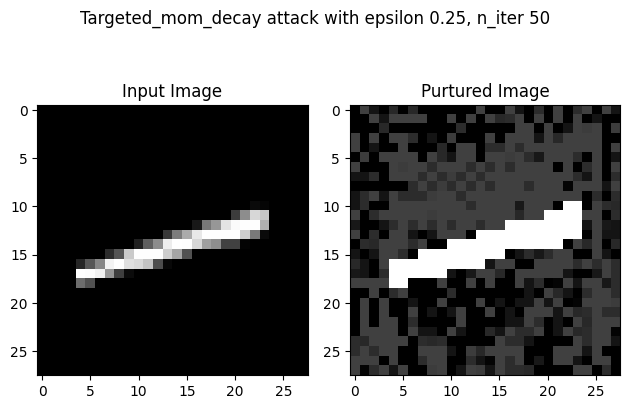

In [255]:
alpha = 20/255
n_iter = 50
model = modelA
letter = 'A'
epsilon_list =[.25, .4]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []
    model.eval()

    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the targeted mom lr decay attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted_mom_decay', epsilon=epsilon, model = 'A', n_iter=n_iter)

In [267]:
# implementing projected gradient descent
def pgd_targeted(input, label, model, alpha=10/255, epsilon=100/255, n_iter=50, class_to_attack=1, target_class=8):
    target_tensor = torch.LongTensor([target_class])
    
    if label != class_to_attack:
        x = norm(input)
        prediction = model(x)
        return x, prediction
    else:
        x=input.detach().clone()
        for i in range(n_iter):
            x.requires_grad = True
            x = norm(x)
            pred=model(x)
            model.zero_grad()
            loss = nn.CrossEntropyLoss()(pred, target_tensor )
            loss.backward()
            gradient=x.grad
            
            with torch.no_grad():
                x = x - alpha*gradient.sign()
                eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
                x = torch.clamp(input + eta, min=0, max=1)
                x = x.detach().clone()
                x = torch.round(x*255)/255
           
        prediction = model(norm(x))
        return prediction,x

In [271]:
norm = Normalize(mean=[0.485], std=[0.229] )

In [282]:

def projected_gradient_descent(input_tensor, model, label, num_iter=100, alpha=10./255, epsilon=100./255):
    norm = Normalize(mean=[0.485], std=[0.229])  # Adjust mean and std if necessary
    if label != 1:
        preds = model(norm(input_tensor))
        return preds, input_tensor
    else:
        adv_tensor = input_tensor.detach().clone()
        for i in range(num_iter):
            adv_tensor.requires_grad = True
            pred = model(norm(adv_tensor))
            model.zero_grad()  # Ensuring gradients are zeroed out correctly
            loss = nn.CrossEntropyLoss()(pred, torch.LongTensor([8]))  # Target class set to 8
            loss.backward()
            grads = adv_tensor.grad

            with torch.no_grad():
                adv_tensor = adv_tensor - alpha * grads.sign()  # Gradient ascent for maximization
                eta = torch.clamp(adv_tensor - input_tensor, min=-epsilon, max=epsilon)
                adv_tensor = torch.clamp(input_tensor + eta, min=0, max=1).detach().clone()
                adv_tensor = torch.round(adv_tensor * 255) / 255  # Optional quantization step

        preds = model(norm(adv_tensor))
        return preds, adv_tensor

In [283]:
adv_tensor = x_test
adv_tensor_labels = y_test

all_preds = []
all_adv_tensors = []

for i in range(len(adv_tensor_labels)):
    adv_tensor_out = adv_tensor[i]
    adv_tensor_out= torch.tensor(np.reshape(adv_tensor_out, (1, 1, 28, 28))).detach().to(dtype=torch.float32)
    y_test_one_sample = torch.tensor([adv_tensor_labels[i]])
    pred, adv_tensor_out = projected_gradient_descent(adv_tensor_out, modelA, y_test_one_sample, 100, 1./255)
    all_preds.append(pred)
    all_adv_tensors.append(adv_tensor_out)
    
final_pred = [torch.argmax(tensor).item() for tensor in all_preds]
all_preds_tensor = torch.cat(all_preds, dim=0)

all_adv_tensors_tensor = torch.cat(all_adv_tensors, dim=0)

print(f"For model A, the test accuracy is: ")
test_accuracy = test(modelA,all_adv_tensors_tensor,y_test,10000)


print(f"Success rate: {targeted_attack_success(final_pred, y_test)}")


For model A, the test accuracy is: 


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8726
Success rate: 0.8167400881057268


In [278]:
all_preds_tensor
print(f"For model A, the test accuracy is: ")
test_accuracy = test(modelA,all_preds_tensor,y_test,10000)




For model A, the test accuracy is: 


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712


In [281]:
print(f"Success rate: {targeted_attack_success(final_pred, y_test)}")

Success rate: 0.0


In [284]:
# PGD attack for targeted adversarial examples
def pgd_targeted(input, label, model, alpha=10/255, epsilon=100/255, n_iter=80, class_to_attack=1, target_class=8):
    # Ensure input tensor does not require gradients
    input = input.detach().clone()
    target_tensor = torch.LongTensor([target_class]).to(input.device)
    
    if label.item() != class_to_attack:
        x = norm(input)
        prediction = model(x)
        return prediction, x
    else:
        x = input.clone()
        for i in range(n_iter):
            x.requires_grad_(True)
            pred = model(norm(x))
            model.zero_grad()
            loss = nn.CrossEntropyLoss()(pred, target_tensor)
            loss.backward()
            gradient = x.grad.data
            
            with torch.no_grad():
                x = x - alpha * gradient.sign()
                eta = torch.clamp(x - input, min=-epsilon, max=epsilon)
                x = torch.clamp(input + eta, min=0, max=1)
                x = torch.round(x * 255) / 255  # Quantization step
                x = x.detach()

        prediction = model(norm(x))
        return prediction, x


In [285]:
# Function to calculate the success rate of the targeted attacks
def targeted_attack_success(preds, labels, class_to_attack=1, target_class=8):
    preds = np.array(preds)
    labels = np.array(labels)
    attack_targets = (labels == class_to_attack)
    successful_attacks = (preds[attack_targets] == target_class).sum()
    total_attacks = attack_targets.sum()
    success_rate = successful_attacks / total_attacks if total_attacks > 0 else 0
    return success_rate

# Assuming you have defined a test function, Normalize, modelA, x_test, and y_test elsewhere
# Replace 'modelA' with your model variable, and adjust 'x_test', 'y_test' as per your dataset

alpha = 10/255
n_iter = 50
model = modelA  # Assuming 'modelA' is defined elsewhere
epsilon_list = [0.05, 0.1, 0.25, 0.4]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model A, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(adv_tensor_labels)):
        input_tensor = torch.tensor(adv_tensor[i:i+1], dtype=torch.float32)
        input_label = torch.tensor([adv_tensor_labels[i]], dtype=torch.long)
        
        pred, adversarial_example = pgd_targeted(input_tensor, input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha=alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
    
    # Concatenating lists of tensors for evaluation
    pred_adv = torch.cat(pred_adv)
    adversarial_inputs = torch.cat(adversarial_inputs)

    # Assuming you have a test function to evaluate accuracy on adversarial examples
    test_accuracy = test(model, adversarial_inputs, y_test, len(y_test))
    final_pred = [torch.argmax(pred, dim=1).item() for pred in pred_adv]
    success_rate = targeted_attack_success(final_pred, y_test)

    print(f'Success rate of the targeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print('Accuracy of the model on original inputs was: [Your Model\'s Original Accuracy Here]')

    # Assuming 'attack_plot' is a function you've defined to visualize the results
    attack_plot(adversarial_inputs, x_test, index=2, name='Targeted', epsilon=epsilon, model='A', n_iter=n_iter)

____________________________________________________________________
Model A, epsilon: 0.05, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
def targeted_attack_success(preds, y_test, class_to_attack=1, target_class=8):
    preds = np.array(preds)
    y_test = np.array(y_test)
    is_class_to_attack = (y_test == class_to_attack)
    correctly_attacked = (preds[is_class_to_attack] == target_class).sum()
    total_class_to_attack = is_class_to_attack.sum()
    if total_class_to_attack > 0:
        success_rate = correctly_attacked / total_class_to_attack 
    else:
        0
    return success_rate

____________________________________________________________________
Model A, epsilon: 0.05, alpha: 0.0392156862745098, n_iter: 50


/var/folders/29/2n699yc91qs65qqg0cqgqtlr0000gp/T/ipykernel_33992/1431641718.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch=torch.tensor(x[start_index:end_index]).float()


accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


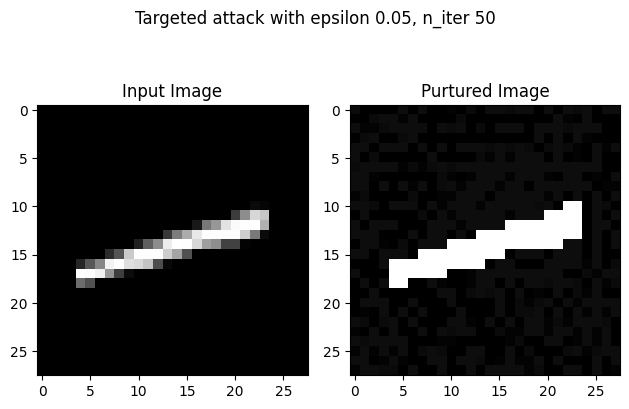

____________________________________________________________________
Model A, epsilon: 0.1, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


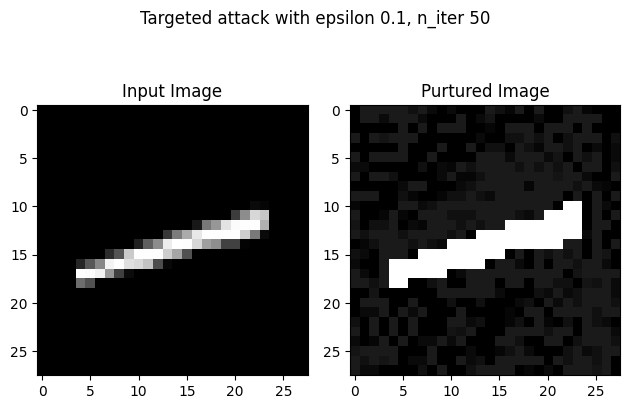

____________________________________________________________________
Model A, epsilon: 0.25, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


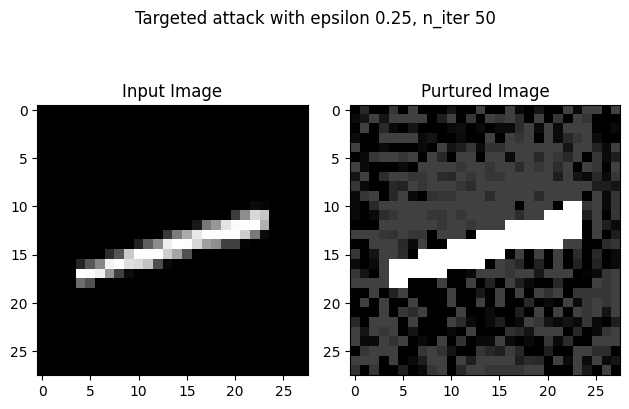

____________________________________________________________________
Model A, epsilon: 0.4, alpha: 0.0392156862745098, n_iter: 50
accuracy: 0.8712
Success rate of the untargeted attack: 0.0
Accuracy of the model on adversarial inputs: 0.8712
Accuracy of the model on inputs was: 0.9856


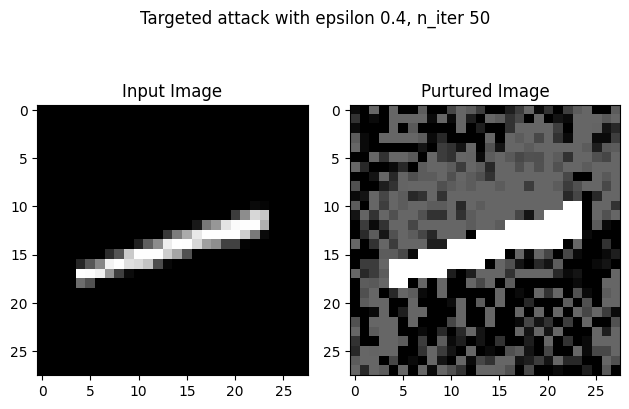

In [ ]:
alpha = 10/255
n_iter = 50
model = modelA
letter = 'A'
epsilon_list =[ 0.05, .1, .25, .4]

for epsilon in epsilon_list:
    print('____________________________________________________________________')
    print(f'Model {letter}, epsilon: {epsilon}, alpha: {alpha}, n_iter: {n_iter}')
    adv_tensor = x_test
    adv_tensor_labels = y_test

    pred_adv = []
    adversarial_inputs = []

    model.eval()
    for i in range(len(adv_tensor_labels)):
        input_tensor = np.expand_dims(x_test[i], axis = 0)
        input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
        input_label = torch.tensor([y_test[i]], dtype=torch.long)
        
        adversarial_example, pred = pgd_targeted(input_tensor,input_label, model=model, epsilon=epsilon, n_iter=n_iter, alpha = alpha)
        pred_adv.append(pred)
        adversarial_inputs.append(adversarial_example)
        
    pred_adv = torch.cat(pred_adv, dim=0)
    pred_adv = torch.cat(adversarial_inputs, dim=0)
    test_accuracy = test(modelA,pred_adv,y_test,10000)
    final_pred = [torch.argmax(tensor).item() for tensor in pred_adv]

    success_rate = targeted_attack_success(final_pred, y_test)


    print(f'Success rate of the untargeted attack: {success_rate}')
    print(f'Accuracy of the model on adversarial inputs: {test_accuracy}')
    print(f'Accuracy of the model on inputs was: {model_A_ref_acc}')

    attack_plot(purturbed_images=pred_adv, test_images=x_test, index=2, name='Targeted', epsilon=epsilon, model = 'A', n_iter=n_iter)